In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
# from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import plot_importance, plot_tree

from src.common.utils import get_date_for_timestamp_file, get_metrics

Importamos las ventas tratadas, luego importamos el archivo de ejemplo para saber cuales son los id_pos que tenemos que entregar

En 01-ventas.parquet tenemos las ventas válidas, las que no tienen unidades positivas y las que correspondientes a los id_pos que se encuentra en el archivo ejemplo. De todas formas, importamos el archivo y realizas el merge para quedarnos solo con las ventas correspondientes a los id_pos (en este caso todas)

*ver [02-analisis_exploratorio_pos](./02-analisis-exploratorio-pos.ipynb)*

In [5]:
df_ventas = pd.read_parquet('../../data/interim/01-ventas.parquet')[['id_pos','fecha','unidades']]
df_ej_resp = pd.read_csv('../../data/raw/ejemploRespuesta.csv', names=["id_pos", "unidades"])

In [6]:
all_pos = df_ej_resp.id_pos.unique()
all_pos

array([   288,    953,   1004, ..., 129492, 129746, 131072])

Función que agrega características de fechas al dataset

In [12]:
def add_date_features(df, col_name="fecha"):
    """
    Esta función transforma una columna que se recibe como parámetro, 
    en varias columnas derivadas. 
    """
    df['year'] = df[col_name].dt.year
    df['dayofyear'] = df[col_name].dt.dayofyear
    df['month'] = df[col_name].dt.month
    df = df.drop([col_name], axis=1, errors='ignore')

def add_unidades_before(df):
    df.unidades = df.unidades.astype('int')
    df.loc[:,"unidades_anterior"] = df.unidades.shift(1).fillna(-1).astype('int')
    df.loc[:,"unidades_12"] = df.unidades.shift(12).fillna(-1).astype('int')
    df.loc[:,"unidades_13"] = df.unidades.shift(13).fillna(-1).astype('int')
    df.loc[:,"unidades_24"] = df.unidades.shift(24).fillna(-1).astype('int')
    df.loc[:,"unidades_25"] = df.unidades.shift(25).fillna(-1).astype('int')
    return df

De todas las ventas, solamente nos quedamos con las que tienen id_pos que aparecen en archivo de respuesta, realizamos un resample de los datos

In [13]:
ventas_totales = (
    df_ventas[lambda df: df.id_pos.isin(all_pos)]
    .set_index('fecha')
    [['id_pos', 'unidades']]
    .groupby('id_pos')
    .resample('M')
    .sum()
    .drop('id_pos', axis=1)
    .fillna(0)
    .reset_index()
)

In [14]:
add_date_features(ventas_totales)

In [15]:
ventas_totales = (
    ventas_totales.sort_values(['year','month'])
    .groupby("id_pos")
    .apply(add_unidades_before)
)

In [16]:
X = ventas_totales.loc[:,["id_pos", 
                          "year", 
                          "month", 
                          "unidades_anterior", 
#                           "unidades_12", 
#                           "unidades_13", 
                          "unidades_24",
                          "unidades_25"
                         ]]

y = ventas_totales.loc[:,['unidades']]

Generamos nuestro modelo de regresión 

In [17]:
# reg = xgb.XGBRFRegressor(
#     n_estimators=250,
#     max_depth=8,
#     missing=-1,
#     early_stopping_rounds=50,
#     objective='reg:squarederror',
#     eval_metric='mae'
# )

reg = RandomForestRegressor(
    n_estimators=250,
    max_depth=8
)

In [18]:
reg.fit(X, y.values.reshape(-1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [19]:
get_metrics(y, np.round(reg.predict(X)))

{'explained_variance_score': 0.739199282956488,
 'mae': 0.8311699268419086,
 'r2': 0.7391992294862253}

## Verificando nuestro modelo
Utilizamos los modelos para realizar las predicción.
En primera instancia, mostramos los valores que predice el modelo para toda la serie en donde tenemos los datos. 

Podemos observar que las predicciones fueron aproximadamente similares para ambos casos. 

In [20]:
df_graph = X[["id_pos", "year", "month"]].copy()
df_graph.loc[:, "unidades"] = y
df_graph.loc[:, "pred"] = np.round(reg.predict(X))

df_graph = df_graph.groupby(["year","month"])[["unidades","pred"]].sum()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0719173240>,
      dtype=object)

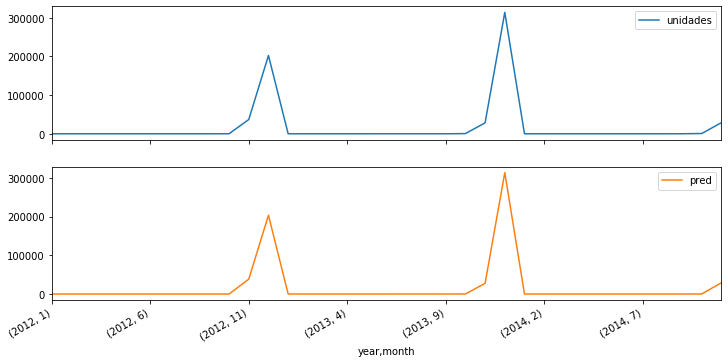

In [21]:
df_graph.plot.line(figsize=(12,6), subplots=True)

### Predicción
Generamos nuestra predicción en X_predict para todos los id_pos para el mes de diciembre

In [22]:
def assign_unidades_anteriores(ventas_totales, year, month):
    return (
        ventas_totales
        .set_index('id_pos')
        [lambda df: (df.year == year) & (df.month==month)]
        .unidades
        .reindex(ventas_totales.id_pos.unique())
        .fillna(0) # o -1?
    )


In [23]:
X_predict = pd.DataFrame({'id_pos':X.id_pos.unique()})
X_predict.loc[:,'fecha'] = pd.date_range('12/1/2014', periods=1, freq='M')
add_date_features(X_predict)

X_predict = X_predict.loc[:,["id_pos", "year", "month"]]

X_predict.loc[:,"unidades_anterior"] = assign_unidades_anteriores(ventas_totales, 2014, 11)
# X_predict.loc[:,"unidades_12"] = assign_unidades_anteriores(ventas_totales, 2013, 12)
# X_predict.loc[:,"unidades_13"] = assign_unidades_anteriores(ventas_totales, 2013, 11)
X_predict.loc[:,"unidades_24"] = assign_unidades_anteriores(ventas_totales, 2012, 12)
X_predict.loc[:,"unidades_25"] = assign_unidades_anteriores(ventas_totales, 2012, 11)
X_predict.fillna(-1, inplace=True)

In [24]:
X_predict.loc[:,"pred"] = np.round(reg.predict(X_predict))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f070bb5fb38>,
      dtype=object)

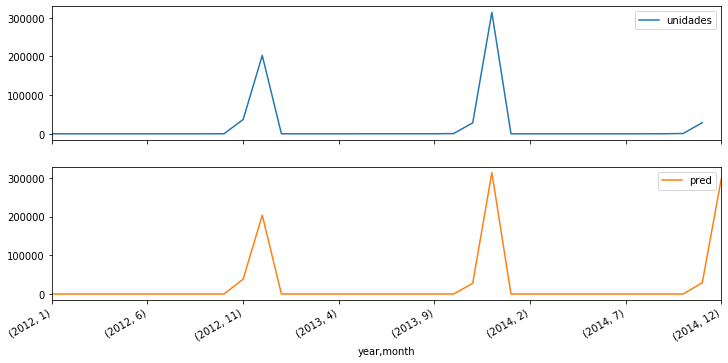

In [25]:
(
    df_graph
    .append(X_predict.groupby(['year','month'])[["pred"]].sum(), sort=False)
    .plot.line(subplots=True, figsize=(12,6))
)

Guardamos la respuesta en un archivo

Me quedo con todos los id_pos del archivo de respuestas, ya que algunos no tienen ventas, a ellos le agregó unidades "0". Los mismos, deben encontrarse ordenados igual que el archivo de ejemplo. 

In [26]:
dt = get_date_for_timestamp_file()

(
    df_ej_resp
    .merge(X_predict[["id_pos","pred"]], how="left")
    .fillna(0)[["id_pos","pred"]]
    .to_csv('../../data/old/rtas/rta-{}.csv'.format(dt), index=False, header=False)
)

Guardamos el modelo para que pueda usarse luego.

In [740]:
import pickle
pickle.dump(reg, open('../models/model_{}'.format(dt), 'wb'))